<a href="https://colab.research.google.com/github/hikaru122700/kaggle-pub/blob/GCI-%E3%82%B3%E3%83%B3%E3%83%9A%EF%BC%92-Home-Credit/007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Credit Default Risk
このnotebookでは、予測結果を作成するまでの流れと基本的な手法についての紹介を行います。


まずは、今回のタスクについて確認しましょう（詳細はREADME.ipynbをご覧ください）。
- **目的**： 顧客データから債務不履行になる確率を予測する。
- **評価指標**： AUC（Area Under the Curve）

## 目次
0. ライブラリ・データの読み込み
1. データの可視化と分析
2. 前処理と特徴量作成
3. 機械学習モデルの作成
4. 予測結果の作成

## 0. ライブラリ・データの読み込み

基本的なライブラリを読み込みます。
他の必要なライブラリについては、説明をする際に読み込みます。
- numpy：数値計算を効率的に行うライブラリ
- pandas：データ分析に便利なライブラリ
- matplotlib：グラフ描画ライブラリ
- seaborn：グラフ描画ライブラリ

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install optuna
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [4]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
from itertools import combinations
import gc

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import optuna
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import log_loss
import time

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:

# すべての列を表示するように設定
pd.set_option('display.max_columns', None)


必要なデータの読み込みを行います。GCIの教材フォルダの構成を想定して、読み込んでいます。

In [6]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。

path  = "/content/drive/My Drive/松尾研/GCI/コンペ２/"

train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")
sample_sub = pd.read_csv(path + "sample_submission.csv")

## 1. データの可視化と分析

### 1.1 データの概観
本格的な分析を行う前に、まずは簡単にデータの概観を確認します。

In [7]:
# trainデータの確認
print(f"train shape: {train.shape}")
train.head(3)

train shape: (171202, 51)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,675000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.010032,-9233,-878,-333.0,-522,NaN,1,1,1,1,0,0,Core staff,2.0,2,2,0,1,1,0,1,1,School,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,585000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.008019,-20148,365243,-4469.0,-3436,NaN,1,0,0,1,0,0,NaN,2.0,2,2,0,0,0,0,0,0,XNA,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,270000.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.004960,-18496,-523,-3640.0,-2050,NaN,1,1,1,1,1,0,Core staff,2.0,2,2,0,0,0,0,0,0,Postal,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN


In [8]:
# testデータの確認
print(f"test shape: {test.shape}")
test.head(3)

test shape: (61500, 50)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,171202,Cash loans,F,N,N,1,144000.0,961146.0,28233.0,688500.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.025164,-12108,-2372,-2446.0,-3022,NaN,1,1,0,1,1,0,Medicine staff,3.0,2,2,0,0,0,0,0,0,Kindergarten,NaN,0.720416,NaN,2.0,0.0,2.0,0.0,-1.0,NaN,NaN,NaN,NaN
1,171203,Cash loans,F,N,N,0,103500.0,296280.0,16069.5,225000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.007020,-17907,-1712,-10450.0,-253,NaN,1,1,1,1,0,0,Cleaning staff,2.0,2,2,0,0,0,0,0,0,School,NaN,0.287306,NaN,5.0,0.0,5.0,0.0,-212.0,NaN,NaN,NaN,NaN
2,171204,Cash loans,F,N,Y,1,180000.0,183694.5,11236.5,139500.0,Children,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.006852,-15221,-553,-1056.0,-4495,NaN,1,1,0,1,0,0,NaN,2.0,3,3,0,0,0,1,1,0,Trade: type 7,NaN,0.352456,0.389339,7.0,0.0,7.0,0.0,-428.0,0.0,1.0,1.0,1.0


In [9]:
train["ORGANIZATION_TYPE"].describe()

,ORGANIZATION_TYPE
count,171202
unique,58
top,Business Entity Type 3
freq,37943


In [10]:
all_df = pd.concat([train, test], axis=0)
all_df.drop("SK_ID_CURR", axis=1, inplace=True)


In [11]:
# 各種商（比率）特徴量
all_df['CREDIT_INCOME_RATIO'] = all_df['AMT_CREDIT'] / (all_df['AMT_INCOME_TOTAL'] + 1e-6)   # クレジット額 / 総収入
all_df['CREDIT_ANNUITY_RATIO'] = all_df['AMT_CREDIT'] / (all_df['AMT_ANNUITY'] + 1e-6)       # クレジット額 / 年金返済額
all_df['CREDIT_GOODS_RATIO'] = all_df['AMT_CREDIT'] / (all_df['AMT_GOODS_PRICE'] + 1e-6)     # クレジット額 / 商品価格
all_df['ANNUITY_INCOME_RATIO'] = all_df['AMT_ANNUITY'] / (all_df['AMT_INCOME_TOTAL'] + 1e-6) # 年金返済額 / 総収入
all_df['GOODS_INCOME_RATIO'] = all_df['AMT_GOODS_PRICE'] / (all_df['AMT_INCOME_TOTAL'] + 1e-6) # 商品価格 / 総収入
all_df['ANNUITY_GOODS_RATIO'] = all_df['AMT_ANNUITY'] / (all_df['AMT_GOODS_PRICE'] + 1e-6)   # 年金返済額 / 商品価格
all_df['EMPLOYED_BIRTH_RATIO'] = all_df['DAYS_EMPLOYED'] / (all_df['DAYS_BIRTH'] + 1e-6)     # 就業日数 / 年齢（日）

# 各種積（プロダクト）特徴量
all_df['CREDIT_INCOME_PRODUCT'] = all_df['AMT_CREDIT'] * all_df['AMT_INCOME_TOTAL']           # クレジット額 × 総収入
all_df['CREDIT_ANNUITY_PRODUCT'] = all_df['AMT_CREDIT'] * all_df['AMT_ANNUITY']               # クレジット額 × 年金返済額
all_df['CREDIT_GOODS_PRODUCT'] = all_df['AMT_CREDIT'] * all_df['AMT_GOODS_PRICE']             # クレジット額 × 商品価格
all_df['INCOME_ANNUITY_PRODUCT'] = all_df['AMT_INCOME_TOTAL'] * all_df['AMT_ANNUITY']         # 総収入 × 年金返済額
all_df['INCOME_GOODS_PRODUCT'] = all_df['AMT_INCOME_TOTAL'] * all_df['AMT_GOODS_PRICE']       # 総収入 × 商品価格
all_df['ANNUITY_GOODS_PRODUCT'] = all_df['AMT_ANNUITY'] * all_df['AMT_GOODS_PRICE']           # 年金返済額 × 商品価格

# DAYS_BIRTH, DAYS_EMPLOYEDを用いた積
# 日数の符号は負となるが、そのまま特徴として使うことで就業期間と年齢関係を非線形的に捉えられる可能性がある
all_df['EMPLOYED_BIRTH_PRODUCT'] = all_df['DAYS_EMPLOYED'] * all_df['DAYS_BIRTH']            # 就業日数 × 年齢（日）

# EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3との組み合わせ特徴量
# EXT_SOURCE_xが存在する場合にのみ処理を実行
for i in range(1, 4):
    ext_source_col = f'EXT_SOURCE_{i}'
    if ext_source_col in all_df.columns:
        all_df[f'CREDIT_EXT_SOURCE_{i}_RATIO'] = all_df['AMT_CREDIT'] / (all_df[ext_source_col] + 1e-6)
        all_df[f'INCOME_EXT_SOURCE_{i}_RATIO'] = all_df['AMT_INCOME_TOTAL'] / (all_df[ext_source_col] + 1e-6)
        all_df[f'CREDIT_EXT_SOURCE_{i}_PRODUCT'] = all_df['AMT_CREDIT'] * all_df[ext_source_col]
        all_df[f'INCOME_EXT_SOURCE_{i}_PRODUCT'] = all_df['AMT_INCOME_TOTAL'] * all_df[ext_source_col]

# 必要に応じて、他の日数系特徴量（DAYS_REGISTRATION, DAYS_ID_PUBLISHなど）との組み合わせや、
# 他の数値特徴量との積・商も追加で生成できます。

# 例として、DAYS_REGISTRATIONとAMT_CREDITの組み合わせを追加する場合：
if 'DAYS_REGISTRATION' in all_df.columns:
    all_df['CREDIT_REGISTRATION_RATIO'] = all_df['AMT_CREDIT'] / (all_df['DAYS_REGISTRATION'].abs() + 1e-6)
    all_df['CREDIT_REGISTRATION_PRODUCT'] = all_df['AMT_CREDIT'] * all_df['DAYS_REGISTRATION']


In [12]:
all_df = pd.get_dummies(all_df)
train = all_df[:train.shape[0]]
test = all_df[train.shape[0]:]

In [13]:
# 特殊文字を含むカラム名を検出
import re

special_chars = r'["\\/\b\f\n\r\t]'
invalid_columns = [col for col in all_df.columns if re.search(special_chars, col)]
print("特殊文字を含むカラム:", invalid_columns)

# 特殊文字をアンダースコアに置換
all_df.columns = [re.sub(special_chars, '_', col) for col in all_df.columns]
all_df.columns = [re.sub(special_chars, '_', col) for col in all_df.columns]


特殊文字を含むカラム: ['NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_HOUSING_TYPE_House / apartment', 'OCCUPATION_TYPE_Waiters/barmen staff']


In [14]:
# trainデータの確認
print(f"train shape: {train.shape}")
train.head(3)

train shape: (171202, 184)


,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,GOODS_INCOME_RATIO,ANNUITY_GOODS_RATIO,EMPLOYED_BIRTH_RATIO,CREDIT_INCOME_PRODUCT,CREDIT_ANNUITY_PRODUCT,CREDIT_GOODS_PRODUCT,INCOME_ANNUITY_PRODUCT,INCOME_GOODS_PRODUCT,ANNUITY_GOODS_PRODUCT,EMPLOYED_BIRTH_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,INCOME_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,INCOME_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,INCOME_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZ

In [15]:
train["TARGET"].value_counts()

,count
TARGET,
0.0,157381
1.0,13821


In [16]:
# testデータの確認
print(f"test shape: {test.shape}")
test.head(3)

test shape: (61500, 184)


,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,GOODS_INCOME_RATIO,ANNUITY_GOODS_RATIO,EMPLOYED_BIRTH_RATIO,CREDIT_INCOME_PRODUCT,CREDIT_ANNUITY_PRODUCT,CREDIT_GOODS_PRODUCT,INCOME_ANNUITY_PRODUCT,INCOME_GOODS_PRODUCT,ANNUITY_GOODS_PRODUCT,EMPLOYED_BIRTH_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,INCOME_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,INCOME_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,INCOME_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZ

In [17]:
train

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,GOODS_INCOME_RATIO,ANNUITY_GOODS_RATIO,EMPLOYED_BIRTH_RATIO,CREDIT_INCOME_PRODUCT,CREDIT_ANNUITY_PRODUCT,CREDIT_GOODS_PRODUCT,INCOME_ANNUITY_PRODUCT,INCOME_GOODS_PRODUCT,ANNUITY_GOODS_PRODUCT,EMPLOYED_BIRTH_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,INCOME_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,INCOME_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,INCOME_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZ

In [18]:
test

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,GOODS_INCOME_RATIO,ANNUITY_GOODS_RATIO,EMPLOYED_BIRTH_RATIO,CREDIT_INCOME_PRODUCT,CREDIT_ANNUITY_PRODUCT,CREDIT_GOODS_PRODUCT,INCOME_ANNUITY_PRODUCT,INCOME_GOODS_PRODUCT,ANNUITY_GOODS_PRODUCT,EMPLOYED_BIRTH_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,INCOME_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,INCOME_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,INCOME_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZ

In [19]:
test.drop("TARGET", axis=1, inplace=True)

In [20]:
# ライブラリの読み込み
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

データを説明変数と目的変数に分割します。今回の目的変数は「TARGET」なので、それ以外が説明変数となります。

In [21]:
# 目的変数と説明変数に分割
train_x = train.drop("TARGET", axis=1)
train_y = train["TARGET"]
test_x = test

In [22]:
# 学習データを学習データとバリデーションデータに分ける
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

In [23]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import time
from sklearn.model_selection import StratifiedKFold

def evaluate(features):
    train_x = tr_x[features]
    train_y = tr_y
    valid_x = va_x[features]
    valid_y = va_y

    # CVパラメータ設定（fold数は適宜調整）
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=13)

    params = {
        "random_state": 13,
        "verbose": 0
    }

    # クロスバリデーションを通じて算出したスコアを格納
    auc_scores = []

    # CVループ
    for train_index, valid_index in skf.split(train_x, train_y):
        X_train_fold, X_valid_fold = train_x.iloc[train_index], train_x.iloc[valid_index]
        y_train_fold, y_valid_fold = train_y.iloc[train_index], train_y.iloc[valid_index]

        model = CatBoostClassifier(**params)
        model.fit(X_train_fold, y_train_fold)

        fold_pred = model.predict_proba(X_valid_fold)[:, 1]
        fold_auc = roc_auc_score(y_valid_fold, fold_pred)
        auc_scores.append(fold_auc)

    # 全fold平均スコア
    mean_auc = sum(auc_scores) / len(auc_scores)

    return mean_auc

def objective(trial):
    # trial.suggest_categorical等で特徴量選択を行う
    # ここでは、特徴量を一つずつ「使用するか・使用しないか」を選択する例を示す
    selected_features = []
    for col in train_x.columns:
        use_feature = trial.suggest_categorical(col, [True, False])
        if use_feature:
            selected_features.append(col)

    # 特徴量が一つも選ばれないケースの回避（少なくとも一つは選ぶ）
    if len(selected_features) == 0:
        return 0.0

    # 評価用関数を使用してスコアを計算
    score = evaluate(selected_features)
    return score

# Optunaによる最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # 試行回数は適宜調整
best_trial = study.best_trial

print("Best Score:", best_trial.value)
print("Best Feature Set:")
best_features = []
for k, v in best_trial.params.items():
    if v == True:
        best_features.append(k)
print(best_features)



[I 2024-12-10 06:26:37,368] A new study created in memory with name: no-name-6aaa59ec-0ae6-4418-8466-675d051a7414
[I 2024-12-10 06:30:36,102] Trial 0 finished with value: 0.7469279030609429 and parameters: {'CNT_CHILDREN': False, 'AMT_INCOME_TOTAL': True, 'AMT_CREDIT': False, 'AMT_ANNUITY': True, 'AMT_GOODS_PRICE': False, 'REGION_POPULATION_RELATIVE': False, 'DAYS_BIRTH': False, 'DAYS_EMPLOYED': True, 'DAYS_REGISTRATION': True, 'DAYS_ID_PUBLISH': False, 'OWN_CAR_AGE': False, 'FLAG_MOBIL': False, 'FLAG_EMP_PHONE': False, 'FLAG_WORK_PHONE': False, 'FLAG_CONT_MOBILE': True, 'FLAG_PHONE': False, 'FLAG_EMAIL': False, 'CNT_FAM_MEMBERS': True, 'REGION_RATING_CLIENT': True, 'REGION_RATING_CLIENT_W_CITY': False, 'REG_REGION_NOT_LIVE_REGION': True, 'REG_REGION_NOT_WORK_REGION': False, 'LIVE_REGION_NOT_WORK_REGION': True, 'REG_CITY_NOT_LIVE_CITY': False, 'REG_CITY_NOT_WORK_CITY': False, 'LIVE_CITY_NOT_WORK_CITY': True, 'EXT_SOURCE_1': True, 'EXT_SOURCE_2': True, 'EXT_SOURCE_3': False, 'OBS_30_CNT

Best Score: 0.7537819442626255
Best Feature Set:
['AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_WORK_REGION', 'EXT_SOURCE_1', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'CREDIT_ANNUITY_RATIO', 'CREDIT_GOODS_RATIO', 'EMPLOYED_BIRTH_RATIO', 'CREDIT_INCOME_PRODUCT', 'CREDIT_ANNUITY_PRODUCT', 'CREDIT_EXT_SOURCE_1_RATIO', 'INCOME_EXT_SOURCE_1_RATIO', 'CREDIT_EXT_SOURCE_1_PRODUCT', 'INCOME_EXT_SOURCE_1_PRODUCT', 'CREDIT_EXT_SOURCE_2_RATIO', 'CREDIT_EXT_SOURCE_2_PRODUCT', 'INCOME_EXT_SOURCE_3_RATIO', 'CREDIT_EXT_SOURCE_3_PRODUCT', 'CREDIT_REGISTRATION_PRODUCT', 'NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_F', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYP

In [24]:
train[list(best_features)]

,AMT_INCOME_TOTAL,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_WORK_REGION,EXT_SOURCE_1,OBS_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,EMPLOYED_BIRTH_RATIO,CREDIT_INCOME_PRODUCT,CREDIT_ANNUITY_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,INCOME_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,INCOME_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_Y,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,112500.0,675000.0,-9233,-878,-522,1,1,0,2.0,2,2,1,NaN,0.0,0.0,-292.0,NaN,20.787811,1.118800,0.095094,8.495888e+10,2.743492e+10,NaN,NaN,NaN,NaN,2.026857e+06,281376.735276,NaN,NaN,-2.514783e+08,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,225000.0,585000.0,-20148,365243,-3436,1,0,0,2.0,2,2,0,NaN,0.0,0.0,-617.0,0.0,34.629728,1.000000,-18.128003,1.316250e+11,9.882405e+09,NaN,NaN,NaN,NaN,1.301249e+06,262996.646938,406749.732494,323601.348781,-2.614365e+09,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,54000.0,270000.0,-18496,-523,-2050,1,1,1,2.0,2,2,0,NaN,4.0,0.0,-542.0,NaN,18.303180,1.237600,0.028276,1.804421e+10,6.100446e+09,NaN,NaN,NaN,NaN,5.867418e+05,190300.683015,NaN,NaN,-1.216313e+09,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False

In [25]:
# @title デフォルトのタイトル テキスト
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import numpy as np
import gc
from itertools import combinations
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


def get_models_trained(train, test, target, num_folds, train_eval):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_eval_predictions = np.zeros(len(train_eval))

    # エラーの累計を保持する辞書
    sum_error = {}
    # 各組み合わせの選択回数を保持する辞書
    combination_count = {}

    # 個別モデルの名前リスト
    model_names = ["model1", "model2", "model3", "model4"]

    # 全ての組み合わせを生成（1, 2, 3, 4モデル）
    all_combinations = []
    for r in range(1, 5):
        all_combinations.extend(combinations(model_names, r))

    # 初期化
    for comb in all_combinations:
        sum_error[comb] = 0
        combination_count[comb] = 0

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"Starting Fold {fold + 1}")
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルと損失の初期化
        loss_dict = {}
        valid_pred_dict = {}

        # モデル1: XGBClassifier
        params1 = {
            "n_estimators": 626,
            "max_depth": 3,
            "random_state": 13,
            "min_child_weight": 0.001190123543553736,
            "learning_rate": 0.010519736270936835,
            "subsample": 0.7304788478701394,
            "colsample_bylevel": 0.604447278915981,
            "colsample_bytree": 0.7616852136157319,
            "reg_alpha": 0.115175569924065,
            "reg_lambda": 0.07155347824929895
        }
        model1 = XGBClassifier(**params1)

        # モデル2: CatBoostClassifier
        params2 = {
            'iterations': 254,
            'depth': 5,
            'learning_rate': 0.08377009991199288,
            'l2_leaf_reg': 1,
            'bagging_temperature': 0.7204457890870082,
            'min_data_in_leaf': 4,
            "random_state": 13,
            "verbose": 0
        }
        model2 = CatBoostClassifier(**params2)

        # モデル3: XGBClassifier
        params3 = {
            "n_estimators": 897,
            "max_depth": 4,
            "min_child_weight": 1.9636282677053687,
            "learning_rate": 0.006151391207761763,
            "subsample": 0.8251910979922186,
            "colsample_bylevel": 0.6454805596196158,
            "colsample_bytree": 0.598042694363472,
            "reg_alpha": 2.1719824223479005,
            "reg_lambda": 0.009192236594241635,
        }
        model3 = XGBClassifier(**params3)

        # モデル4: CatBoostClassifier
        params4 = {
            "iterations": 940,
            "depth": 3,
            "learning_rate": 0.019908189422344794,
            "l2_leaf_reg": 1,
            "bagging_temperature": 0.5063893392618839,
            "min_data_in_leaf": 1,
            'random_state': 42
        }
        model4 = CatBoostClassifier(**params4, verbose=0)

        # 各モデルの訓練と予測
        models = {
            "model1": model1,
            "model2": model2,
            "model3": model3,
            "model4": model4
        }

        for name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict_proba(X_valid)[:, 1]
            auc = roc_auc_score(y_valid, preds)
            print(f"Fold {fold + 1} AUC for {name} = {auc}")
            loss_dict[(name,)] = auc  # キーをタプルに変更
            valid_pred_dict[(name,)] = preds
            sum_error[(name,)] += auc

        # すべての2モデルおよび3モデルの組み合わせを評価
        for r in [2, 3]:
            for comb in combinations(model_names, r):
                # 平均予測
                preds_comb = np.mean([valid_pred_dict[(comb_part,)] for comb_part in comb], axis=0)
                auc_comb = roc_auc_score(y_valid, preds_comb)
                print(f"Fold {fold + 1} AUC for {comb} = {auc_comb}")
                loss_dict[comb] = auc_comb
                valid_pred_dict[comb] = preds_comb
                sum_error[comb] += auc_comb

        # 全モデルのアンサンブル
        preds_all = np.mean([valid_pred_dict[(model,)] for model in model_names], axis=0)
        auc_all = roc_auc_score(y_valid, preds_all)
        print(f"Fold {fold + 1} AUC for all models ensemble = {auc_all}")
        loss_dict[tuple(model_names)] = auc_all
        valid_pred_dict[tuple(model_names)] = preds_all
        sum_error[tuple(model_names)] += auc_all

        # 最適な組み合わせを選択
        best_combination = max(loss_dict, key=loss_dict.get)  # AUCが高い組み合わせを選択
        best_auc = loss_dict[best_combination]
        print(f"Fold {fold + 1} best combination: {best_combination} with AUC = {best_auc}")

        # OOF予測とテスト予測の更新
        if isinstance(best_combination, tuple):
            # 複数モデルのアンサンブル
            oof_predictions[valid_index] = valid_pred_dict[best_combination]
            test_preds = np.mean([models[model].predict_proba(test)[:, 1] for model in best_combination], axis=0)
            train_eval_preds = np.mean([models[model].predict_proba(train_eval)[:, 1] for model in best_combination], axis=0)
        else:
            # 単一モデル（この場合は常にタプルになるため不要）
            oof_predictions[valid_index] = valid_pred_dict[(best_combination,)]
            test_preds = models[best_combination].predict_proba(test)[:, 1]
            train_eval_preds = models[best_combination].predict_proba(train_eval)[:, 1]

        # 各組み合わせの選択回数をインクリメント
        combination_count[best_combination] += 1

        test_predictions += test_preds / kf.n_splits
        train_eval_predictions += train_eval_preds / kf.n_splits

        # メモリの解放
        del X_train, X_valid, y_train, y_valid, model1, model2, model3, model4
        gc.collect()

        print('---------------\n')

    final_AUC = roc_auc_score(target, oof_predictions)
    print(f"OOF AUC = {final_AUC}")

    # 各組み合わせの累積エラーと選択回数を表示
    print("Sum of AUC for each combination:")
    for comb, error in sum_error.items():
        print(f"{comb}: {error}")

    print("\nNumber of times each combination was selected:")
    for comb, count in combination_count.items():
        print(f"{comb}: {count}")

    return oof_predictions, test_predictions, train_eval_predictions


In [26]:
# 目的変数と説明変数に分割
X = train[list(best_features)].values
y = train["TARGET"].values
X_test = test[list(best_features)].values

In [27]:
oof_predictions, test_preds, train_preds = get_models_trained(X, X_test, y, 5, X)

Starting Fold 1
Fold 1 AUC for model1 = 0.7392576492519565
Fold 1 AUC for model2 = 0.749299976781113
Fold 1 AUC for model3 = 0.7421645110925865
Fold 1 AUC for model4 = 0.7447074979886387
Fold 1 AUC for ('model1', 'model2') = 0.7466529850731867
Fold 1 AUC for ('model1', 'model3') = 0.7408885109964144
Fold 1 AUC for ('model1', 'model4') = 0.7431713780210746
Fold 1 AUC for ('model2', 'model3') = 0.7476807959962075
Fold 1 AUC for ('model2', 'model4') = 0.7478776808965728
Fold 1 AUC for ('model3', 'model4') = 0.7445284807562378
Fold 1 AUC for ('model1', 'model2', 'model3') = 0.7456678794658471
Fold 1 AUC for ('model1', 'model2', 'model4') = 0.7463686121696436
Fold 1 AUC for ('model1', 'model3', 'model4') = 0.7431659178252102
Fold 1 AUC for ('model2', 'model3', 'model4') = 0.7471133556413553
Fold 1 AUC for all models ensemble = 0.7458102872769103
Fold 1 best combination: ('model2',) with AUC = 0.749299976781113
---------------

Starting Fold 2
Fold 2 AUC for model1 = 0.7435944198061316
Fold 

In [28]:
test_preds

array([0.05687955, 0.17747379, 0.14798297, ..., 0.04065413, 0.17113616,
       0.12752912])

In [29]:
# 予測結果を提出用のフォーマットに格納
sample_sub['TARGET'] = test_preds
sample_sub

,SK_ID_CURR,TARGET
0,171202,0.056880
1,171203,0.177474
2,171204,0.147983
3,171205,0.115127
4,171206,0.151985
...,...,...
61495,232697,0.135262
61496,232698,0.036235
61497,232699,0.040654
61498,232700,0.171136


In [45]:
# 提出用のcsvファイルを作成
sample_sub.to_csv('GCI-コンペ２_007.csv',index=False)

以上で、Home Credit Default Riskコンペのチュートリアルは終了です。今回は、50種類ある特徴量のうち5種類しか使用していないので、まだまだ改善の余地があります。この後は、このnotebookやこれまでの教材を参考にして、さらなるスコアの向上を目指してください！

In [32]:
train

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_RATIO,ANNUITY_INCOME_RATIO,GOODS_INCOME_RATIO,ANNUITY_GOODS_RATIO,EMPLOYED_BIRTH_RATIO,CREDIT_INCOME_PRODUCT,CREDIT_ANNUITY_PRODUCT,CREDIT_GOODS_PRODUCT,INCOME_ANNUITY_PRODUCT,INCOME_GOODS_PRODUCT,ANNUITY_GOODS_PRODUCT,EMPLOYED_BIRTH_PRODUCT,CREDIT_EXT_SOURCE_1_RATIO,INCOME_EXT_SOURCE_1_RATIO,CREDIT_EXT_SOURCE_1_PRODUCT,INCOME_EXT_SOURCE_1_PRODUCT,CREDIT_EXT_SOURCE_2_RATIO,INCOME_EXT_SOURCE_2_RATIO,CREDIT_EXT_SOURCE_2_PRODUCT,INCOME_EXT_SOURCE_2_PRODUCT,CREDIT_EXT_SOURCE_3_RATIO,INCOME_EXT_SOURCE_3_RATIO,CREDIT_EXT_SOURCE_3_PRODUCT,INCOME_EXT_SOURCE_3_PRODUCT,CREDIT_REGISTRATION_RATIO,CREDIT_REGISTRATION_PRODUCT,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZ

In [39]:
train["oof_predictions"] = oof_predictions
train.loc[:, ["TARGET", "oof_predictions"]]

,TARGET,oof_predictions
0,0.0,0.102836
1,0.0,0.041856
2,0.0,0.077395
3,0.0,0.072890
4,1.0,0.140443
...,...,...
171197,0.0,0.060399
171198,0.0,0.082500
171199,0.0,0.026942
171200,0.0,0.050658


In [42]:
train.loc[train["oof_predictions"] >= 0.6, ["TARGET", "oof_predictions"]]

,TARGET,oof_predictions
683,1.0,0.602900
783,1.0,0.630836
1362,1.0,0.762806
2134,1.0,0.626313
2292,0.0,0.636913
...,...,...
161706,0.0,0.638929
162190,0.0,0.720673
163372,1.0,0.689437
165085,0.0,0.643187


In [44]:
filtered_data = train.loc[train["oof_predictions"] >= 0.6, "TARGET"]
filtered_data.value_counts()

,count
TARGET,
1.0,73
0.0,52


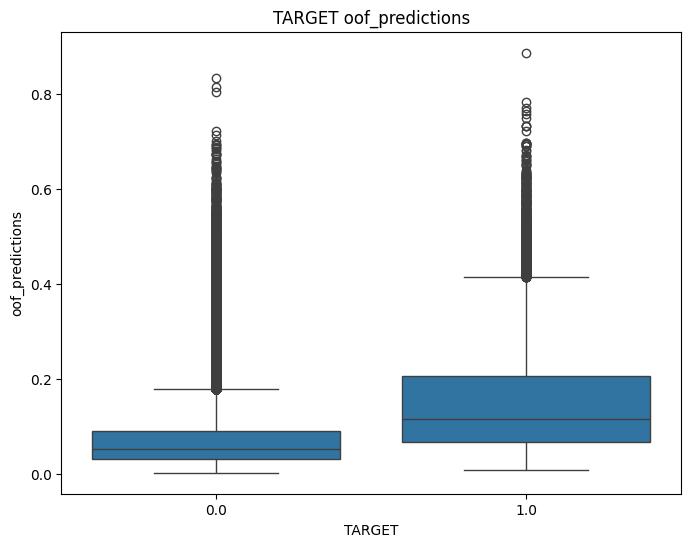

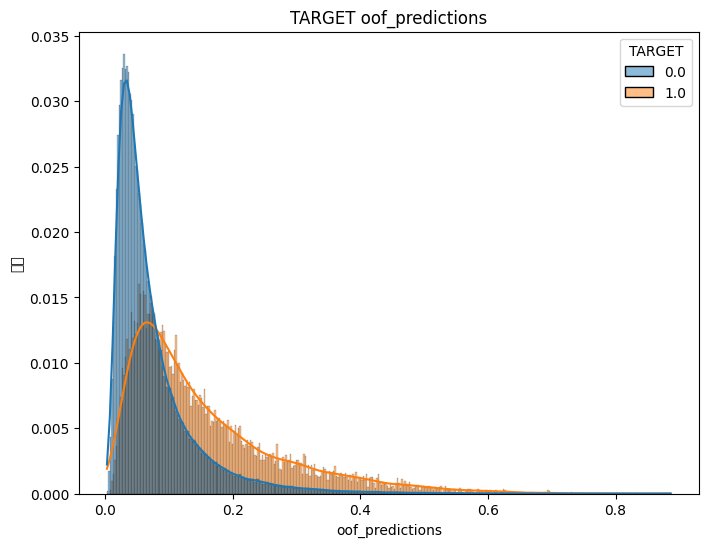

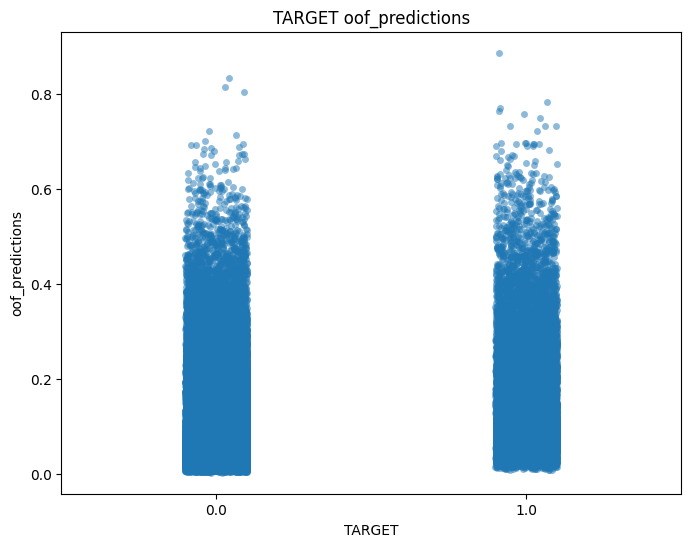

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# 可視化1: TARGETごとのoof_predictions分布を箱ひげ図で可視化
plt.figure(figsize=(8, 6))
sns.boxplot(x='TARGET', y='oof_predictions', data=train)
plt.title('TARGET oof_predictions')
plt.xlabel('TARGET')
plt.ylabel('oof_predictions')
plt.show()

# 可視化2: TARGETごとのoof_predictions分布をヒストグラム＋カーネル密度推定で可視化
plt.figure(figsize=(8, 6))
sns.histplot(data=train, x='oof_predictions', hue='TARGET', kde=True, stat='probability', common_norm=False)
plt.title('TARGET oof_predictions')
plt.xlabel('oof_predictions')
plt.ylabel('割合')
plt.show()

# 可視化3: TARGETとoof_predictionsの相関を散布図で可視化（分類だと情報量は少ないが例示）
# ※TARGETが0/1の二値であれば、x軸はoof_predictionsでy軸はTARGETで散布は限定的だが、傾向を見る参考になる
plt.figure(figsize=(8, 6))
sns.stripplot(x='TARGET', y='oof_predictions', data=train, jitter=True, alpha=0.5)
plt.title('TARGET oof_predictions')
plt.xlabel('TARGET')
plt.ylabel('oof_predictions')
plt.show()
